# Predict steering angle with a simple ConvNet

In [1]:
import pandas as pd
import os, sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import AveragePooling2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.models import load_model
from keras import metrics
import keras as K

Using TensorFlow backend.


In [2]:
import pandas as pd
steering_labels = pd.read_csv("/home/ubuntu/dataset/udacity-driving/interpolated.csv")
print(steering_labels.shape)
steering_labels.head()

(45636, 12)


index            timestamp  width  height  \
0  2016-09-29 22:09:25.602401049  1475186965602401049    640     480   
1  2016-09-29 22:09:25.609972775  1475186965609972775    640     480   
2  2016-09-29 22:09:25.630938502  1475186965630938502    640     480   
3  2016-09-29 22:09:25.652132892  1475186965652132892    640     480   
4  2016-09-29 22:09:25.659735933  1475186965659735933    640     480   

        frame_id                        filename     angle    torque  \
0    left_camera    left/1475186965602401049.jpg -0.045649 -0.644359   
1  center_camera  center/1475186965609972775.jpg -0.046314 -0.691983   
2   right_camera   right/1475186965630938502.jpg -0.047124 -0.677232   
3    left_camera    left/1475186965652132892.jpg -0.047124 -0.585284   
4  center_camera  center/1475186965659735933.jpg -0.047099 -0.560746   

       speed  lat  long  alt  
0  14.605986  0.0   0.0  0.0  
1  14.607044  0.0   0.0  0.0  
2  14.611567  0.0   0.0  0.0  
3  14.615654  0.0   0.0  0.0  
4  14.616667  0.0   0.0  0.0

In [3]:
def generate_train_batch(data, batch_size = 16):

    img_rows = 480
    img_cols = 640
    
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    angles = np.zeros((batch_size, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(30000)
            
            file_name = steering_labels.iloc[i_line]["filename"]
            img_bgr = cv2.imread("/home/ubuntu/dataset/udacity-driving/" + file_name)
            
            b,g,r = cv2.split(img_bgr)       # get b,g,r
            rgb_img = cv2.merge([r,g,b])     # switch it to rgb
            
            f =  float(steering_labels.iloc[i_line]["angle"]) #float(* 180.00 / 3.14159265359 )
    
            batch_images[i_batch] = rgb_img
            angles[i_batch] = f
        yield batch_images, angles

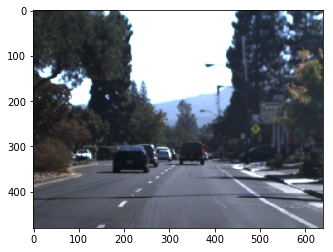

[ 0.05061455]


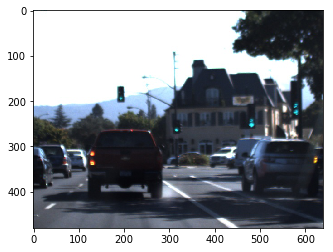

[ 0.08203048]


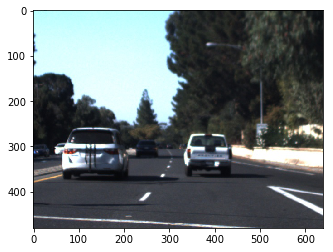

[ 0.03490658]


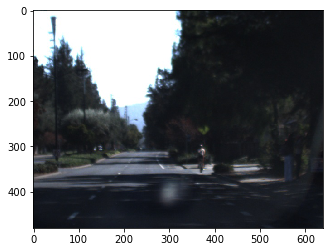

[ 0.00924287]


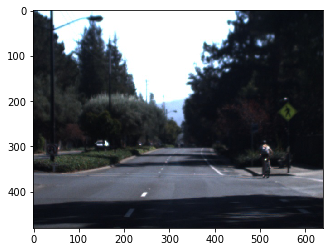

[ 0.05102035]


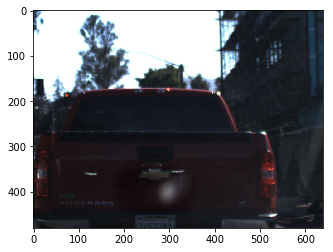

[ 0.04014257]


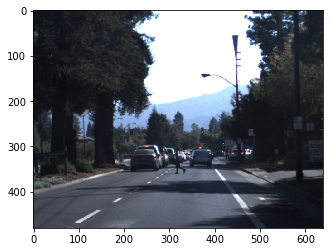

[ 0.00623367]


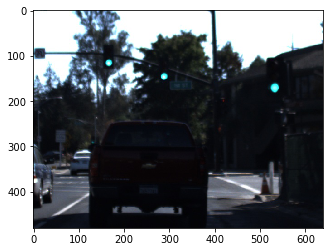

[ 0.03665191]


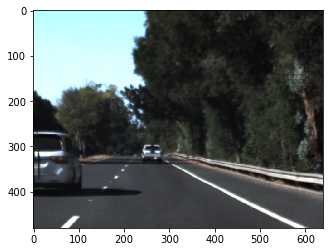

[ 0.02443461]


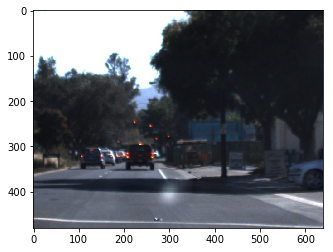

[ 0.06632251]
(20, 480, 640, 3)
(20, 1)


In [4]:
# testing the generator
training_gen = generate_train_batch(steering_labels, 20)
batch_img, steering_angle = next(training_gen)

for i in range(10):
    im = np.array(batch_img[i], dtype=np.uint8)
    steering = steering_angle[i]
    plt.imshow(im)
    plt.show();
    print(steering)
    
print(batch_img.shape)
print(steering_angle.shape)

In [5]:
# # frame size
# nrows = 480
# ncols = 640

# # model start here
# model = Sequential()

# model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', input_shape=(480, 640, 3)))
# model.add(Conv2D(12,(5,5),padding='valid', activation='relu', strides=(2,2)))
# model.add(Conv2D(24,(5,5),padding='valid', activation='relu', strides=(2,2)))
# model.add(Conv2D(24,(5,5),padding='valid', activation='relu', strides=(2,2)))
# model.add(Conv2D(48,(3,3),padding='valid', activation='relu', strides=(1,1)))
# model.add(Conv2D(64,(3,3),padding='valid', activation='relu', strides=(1,1)))
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1, activation=None))

# model.summary()

In [19]:
def create_comma_model_prelu():
    model = Sequential()

    model.add(Conv2D(16, 8, 8, subsample=(4, 4), border_mode="same", input_shape=(480, 640, 3)))
    model.add(PReLU())
    model.add(Conv2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(PReLU())
    model.add(Conv2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    #model.add(Dropout(.5))
    model.add(PReLU())
    model.add(Dense(512))
    #model.add(Dropout(.5))
    model.add(PReLU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    print('Model is created and compiled..')
    return model

In [5]:
def create_nvidia_model1():
    model = Sequential()

    model.add(Conv2D(24, (5, 5), subsample=(2, 2), border_mode="same", input_shape=(480, 640, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(36, (5, 5), subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (5, 5), subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    print('Model is created and compiled..')
    return model

In [21]:
# def root_mean_squared_error(y_true, y_pred):
#         return K.backend.sqrt(K.backend.mean(K.backend.square(y_pred - y_true), axis=-1)) 

In [22]:
# def acc(y_true, y_pred):
#     # Symbolically compute the intersection
#     a = abs((y_pred - y_true) / y_true)
#     print(abs(y_pred - y_true))
#     # Technically this is the negative of the Sorensen-Dice index. This is done for
#     # minimization purposes
#     return a

In [6]:
model = create_nvidia_model1()
model.summary()

/home/ubuntu/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(480, 640,..., strides=(2, 2), padding="same")`
  after removing the cwd from sys.path.
/home/ubuntu/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), padding="same")`
  
/home/ubuntu/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), padding="same")`
  
/home/ubuntu/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/miniconda3/envs/tensorflow/lib/python3.

Model is created and compiled..
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 320, 24)      1824      
_________________________________________________________________
activation_1 (Activation)    (None, 240, 320, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 36)      21636     
_________________________________________________________________
activation_2 (Activation)    (None, 120, 160, 36)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 80, 48)        43248     
_________________________________________________________________
activation_3 (Activation)    (None, 60, 80, 48)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 40, 

In [ ]:
generator = generate_train_batch(steering_labels, 1)
history = model.fit_generator(generator, steps_per_epoch=10000, epochs=3, verbose=1)

Epoch 1/3
 3075/10000 [========>.....................] - ETA: 288s - loss: 0.3408

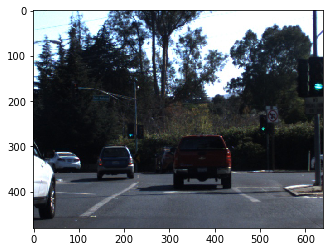

[-0.04508846]
[ 4.65463114]


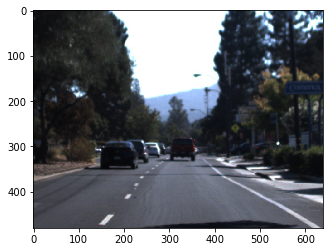

[ 0.06283186]
[-2.76483798]


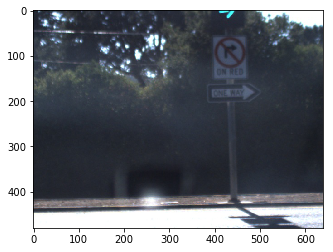

[-3.67042732]
[ 15.27649307]


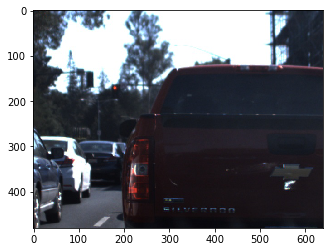

[ 0.03141593]
[-2.35829139]


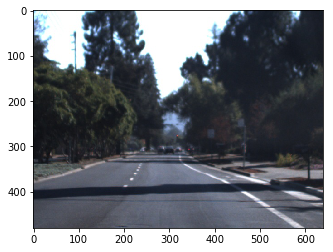

[ 0.00349066]
[ 2.04794717]


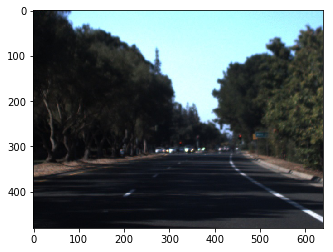

[-0.00199474]
[ 2.97889447]


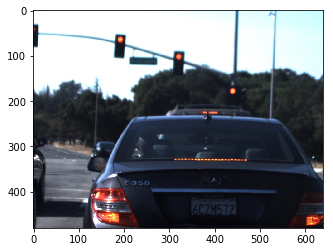

[ 0.11868239]
[ 4.13083315]


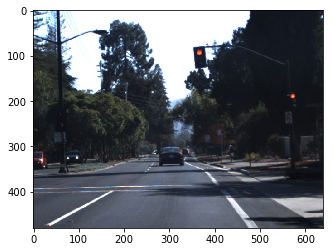

[ 0.04295324]
[ 4.98971415]


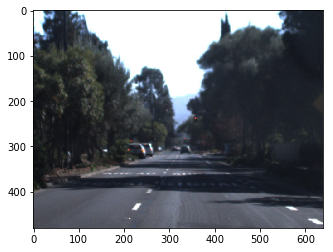

[ 0.02792527]
[ 0.40888047]


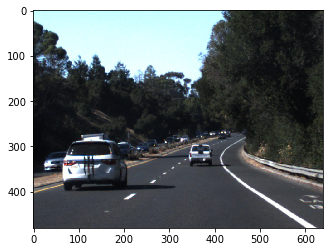

[ 0.01775459]
[ 1.1858809]


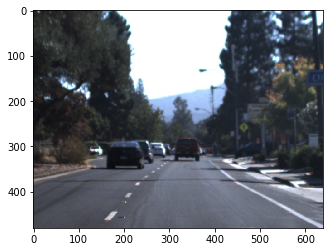

[ 0.05410521]
[-1.77948165]


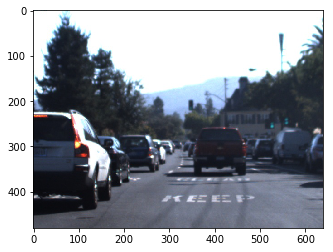

[-0.00451767]
[-0.66852164]


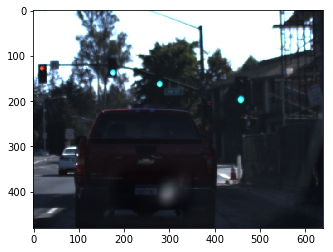

[ 0.02792527]
[ 3.90150094]


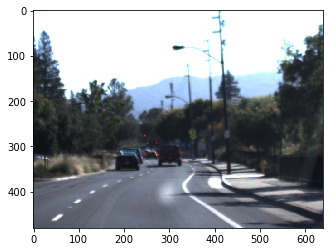

[ 0.01047198]
[ 2.99903893]


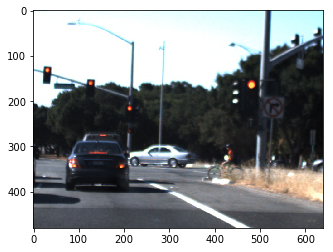

[ 0.09645502]
[ 4.0018754]


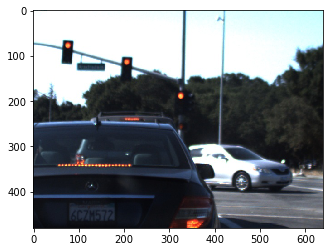

[ 0.11868239]
[ 4.20210314]


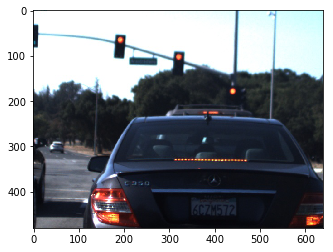

[ 0.11868239]
[ 4.23199511]


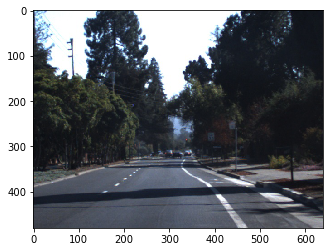

[ 0.00349066]
[ 3.58998036]


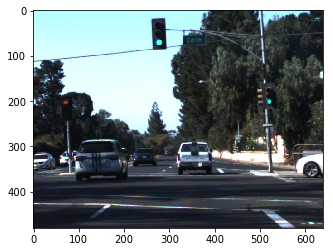

[ 0.02094395]
[ 7.63378954]


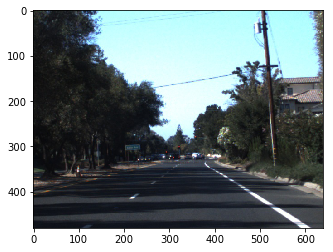

[ 0.04296254]
[-3.1486299]


In [26]:
# testing the results
model.save('trained-v2.h5')
predictions = model.predict(batch_img)

for i in range(20):
    im = np.array(batch_img[i], dtype=np.uint8)
    plt.imshow(im)
    plt.show();
    print(steering_angle[i])
    print(predictions[i])
#model.save('trained.h5')